# HFF Turbidity Analysis

## Business Understanding

Henry's Fork Foundation aims to preserve and restore the natural water quality of the Henry's Fork of the Snake River and its watershed. While their responsibilities are many, one of their chief aims is to use modern scientific techniques to keep tabs on the river and ensure local industrial and commercial practices are not interfering with its overall health and aesthetics. In turn, the river provides habitat for local flora and fauna, not to mention a large portion of the tourism revenue for the surrounding towns in the form of sport fishing.

To ensure optimal fishing experience the water conditions must be within acceptable ranges. Turbidity is the measure of clarity of a liquid, and in this case is very important to this experience. According to my correspondence with their Senior Scientist, Rob Van Kirk, "Turbidity is the single biggest factor affecting fishing experience. Anglers can't see things like dissolved oxygen or nutrient concentrations, but they can see how clear or dirty the water is. By far the single biggest complaint I get about fishing conditions is how turbid the water is."

I have been tasked with assessing and modeling data from multiple sources to determine major factors and predictors that contribute to turbidity in the river. Using this analysis and its framework, future scientists may be able to forecast water clarity and even mitigate contributing factors.

## Data Understanding

The first dataset comes from the publically available sonde data at [HFF.org](https://henrysforkdata.shinyapps.io/scientific_website/). This data is updated every 15 minutes using an in-water monitoring device called a sonde. These devices measure water temperature, turbidity, dissolved oxygen, conductivity, phytoplankton, and cyanobacteria content. While the other factors can contribute to the turbidity of a system on their own, they do not provide a complete picture.

We chose the sonde at this location because it is the head of one of the best regarded fishing areas, and its location just a few hundred yards downstream from Island Park Dam makes turbidity there less predictable and of higher concern. Determining the contributing factors to water clarity here could prove valuable in understanding how activity and management at Island Park reservoir impact the downstream water conditions.

The second dataset comes from the [US Bureau of Reclamation](https://www.usbr.gov/projects/index.php?id=151) and contains historical data regarding the water in island park reservoir, including in/outflow, elevation, and overall change in volume. While this data does not directly address the clarity of the water, the rate of flow in and out of the reservoir may kick up sediment and with the amount of exposed shoreline may affect the rate at which the shoreline erodes into the reservoir. This data dates back to 1929 which may be interesting to explore further once we have established the relevant tools for the job.

The third dataset comes from the [USDA Snotel Natural Resources Conservation Service
National Water and Climate Center](https://wcc.sc.egov.usda.gov/reportGenerator/view/customChartReport/daily/start_of_period/546:ID:SNTL%7Cid=%22%22%7Cname/CurrentWY,CurrentWYEnd/WTEQ::median_1981,WTEQ::median_1991,PREC::average_1981,PREC::median_1991?fitToScreen=false&useLogScale=false) which provides snow and climate monitoring at specific sites across the entire USA. The dataset we have is localized to our region, which we narrow further to sites that affect the watershed into the reservoir's tributaries. This has been collected since 1988 for this locale, which we again narrow into a timeframe we can use. The data includes the temperature at these sites, the daily and average precipitation, and the amount of water currently at the site in the form of snow.

## Data Preparation

First we import relevant libraries and format the data to be readable as a timeseries. Then, in order to get the data into a time scale that is relevant to the other datasets we downsample to daily frequency and split the data into training and testing sets. The data is in a timeseries, which precludes traditional random train/test splitting, and must be done using values that are in sequence. In this case, we take the most recent year with relatively complete data as the test set, and the rest of the complete years as the training data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from matplotlib.pyplot import figure

from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer, OrdinalEncoder, MaxAbsScaler

from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error


from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.seasonal import STL

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [2]:
# Import raw Island Park Dam sonde data
ipe_df = pd.read_csv('data/15_min_data_HFF/IPE 15 min 2022-08-08.csv')
ipe_df

,contTime,Turb_FNU,TurbDailyMn,TurbSamp_NTU,Chloro_RFU,ChloroDailyMn,BGA_RFU,BGADailyMn,ODO_mgL,ODODailyMn,...,Temp_C_raw,Cond_muSCm_raw,TDS_mgL_raw,TotalPres_psi_raw,Turb_avdymn,Chlor_avdymn,Cyano_avdymn,Temp_avdymn,ODO_avdymn,Cond_avdymn
0,2014-06-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-06-20 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-06-20 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-06-20 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-06-20 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285217,2022-08-07 23:00:00,5.48,NaN,NaN,0.34,NaN,0.02,NaN,7.49,NaN,...,18.66,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285218,2022-08-07 23:15:00,5.74,NaN,NaN,0.27,NaN,0.03,NaN,7.48,NaN,...,18.64,123.5,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285219,2022-08-07 23:30:00,6.37,NaN,NaN,0.29,NaN,0.03,NaN,7.47,NaN,...,18.64,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285220,2022-08-07 23:45:00,6.40,NaN,NaN,0.34,NaN,0.02,NaN,7.48,NaN,...,18.63,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Convert date to index and DateTime format
ipe_df = ipe_df.rename(columns={'contTime': 'date'})
ipe_df['date'] = pd.to_datetime(ipe_df.date)
data = ipe_df.drop(['date'], axis=1)
data.index = ipe_df.date

In [4]:
# Downsample data to daily frequency 
ipe_daily = data.resample('D').mean()

In [5]:
ipe_daily = ipe_daily.drop(['TurbDailyMn', 'TurbSamp_NTU',
       'ChloroDailyMn', 'BGADailyMn', 'ODODailyMn',
       'TempDailyMn', 'CondDailyMn', 'TDS_mgL',
       'TotalPres_psi', 'AshtonAirPres_psi', 'Depth_ft', 'Shift_psi',
       'Turb_FNU_raw', 'Chloro_RFU_raw', 'BGA_RFU_raw', 'ODO_mgL_raw',
       'Temp_C_raw', 'Cond_muSCm_raw', 'TDS_mgL_raw', 'TotalPres_psi_raw',
       'Turb_avdymn', 'Chlor_avdymn', 'Cyano_avdymn', 'Temp_avdymn',
       'ODO_avdymn', 'Cond_avdymn'], axis=1)

In [6]:
ipe_interp = ipe_daily.interpolate(method='spline', order=2)

In [7]:
ipe_train = ipe_interp['2016':'2020']

In [8]:
ipe_test = ipe_interp['2021']

C:\Users\harri\AppData\Local\Temp\ipykernel_16212\3605300567.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  ipe_test = ipe_interp['2021']


<AxesSubplot:xlabel='date'>

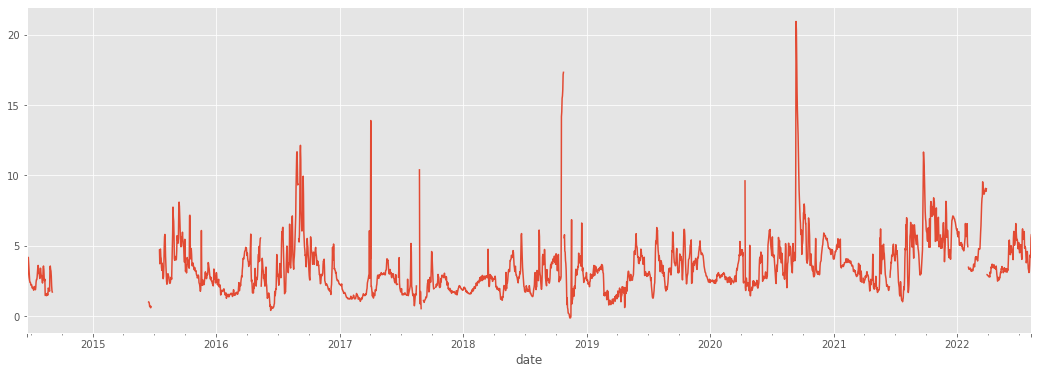

In [9]:
ipe_daily['Turb_FNU'].plot(figsize=(18,6))

When we inspect the turbidity values here, we see there is a rather large gap early on in the time series, and a few smaller ones later on. These may bee too large for simple interpolation, especially with the high variance in data values over a short period of time. For this reason we will later drop these sections. Other NaN values will be interpolated over using the splining method to attempt to anticipate the patterns before modeling.

In [10]:
# import island park dam hydrology data
hydro_df = pd.read_csv('data/IslandPark.TS.csv')

# set the datetime to the index
hydro_df['date'] = pd.to_datetime(hydro_df['date'])
hydro_df.set_index(['date'], inplace=True)
hydro_df.index.names = ['date']
hydro_df.columns

Index(['elevation.ft', 'volume.af', 'smoothed.vol', 'smoothed.elev',
       'surfacearea.acres', 'net.evap.af', 'delta.V.af', 'regQ.cfs',
       'gain.cfs', 'smoothed.natQ.cfs'],
      dtype='object')

In [11]:
# drop redundant columns
hydro_df.drop(['volume.af', 'smoothed.vol', 'elevation.ft',
                   'smoothed.elev', 'surfacearea.acres'], axis=1, inplace=True)

In [12]:
hydro_df = hydro_df['2014':'2022']

In [13]:
# set the range of the data to the same as the sonde data
hydro_interp = hydro_df.interpolate(method='spline', order=2)

In [14]:
hydro_df_train = hydro_interp['2016':'2020']

In [15]:
hydro_df_test = hydro_interp['2021']

C:\Users\harri\AppData\Local\Temp\ipykernel_16212\1673822024.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  hydro_df_test = hydro_interp['2021']


In [16]:
climate_df = pd.read_csv('data/Clean.Climate.TS.csv')
climate_df['Date'] = pd.to_datetime(climate_df['Date'])
climate_df.set_index(['Date'], inplace=True)
climate_df.drop(['GT.TAVE', 'GT.TMIN', 'GT.TMAX', 'GT.DP', 'GT.AP', 'GT.SWE', 'PB.TAVE',
       'PB.TMIN', 'PB.TMAX', 'PB.DP','HFW.AP', 'TR.SWE', 'FR.SWE', 'HF.SWE', 'HFW.SWE', 'AG.DP', 'AG.ET',
       'HFW.Cum.P', 'AG.Cum.P', 'AG.Cum.ET', 'PB.AP', 'PB.SWE', 'BB.TAVE', 'BB.TMIN', 'BB.TMAX', 'BB.DP', 'BB.AP',
       'BB.SWE', 'LL.TAVE', 'LL.TMIN', 'LL.TMAX', 'LL.DP', 'LL.AP', 'LL.SWE', 'GL.TAVE',
       'GL.TMIN', 'GL.TMAX', 'GL.DP', 'GL.AP', 'GL.SWE', 'PC.TAVE', 'PC.TMIN', 'PC.TMAX',
       'PC.DP', 'PC.AP', 'PC.SWE', 'AL.TAVE', 'AL.TMIN', 'AL.TMAX', 'AL.DP', 'AL.AP',
       'AS.TAVE', 'AS.TMIN', 'AS.TMAX', 'AS.DP', 'AS.AP', 'AS.ET', 'RX.TAVE',
       'RX.TMIN', 'RX.TMAX', 'RX.DP', 'RX.AP', 'RX.ET', 'TR.TAVE', 'FR.TAVE',
       'HF.TAVE', 'VA.TAVE', 'HFW.TAVE', 'TR.TMIN', 'FR.TMIN', 'HF.TMIN',
       'VA.TMIN', 'HFW.TMIN', 'TR.TMAX', 'FR.TMAX', 'HF.TMAX', 'VA.TMAX',
       'HFW.TMAX', 'TR.DP', 'FR.DP', 'HF.DP', 'VA.DP', 'HFW.DP', 'TR.AP',
       'FR.AP', 'HF.AP', 'VA.AP', 'WE.TMIN', 'WE.TMAX', 'CC.TMIN', 'CC.TMAX',
       'IP.TMIN', 'IP.TMAX'], axis=1, inplace=True)
climate_df.index.names = ['date']
climate_df.columns

Index(['WE.TAVE', 'WE.DP', 'WE.AP', 'WE.SWE', 'CC.TAVE', 'CC.DP', 'CC.AP',
       'CC.SWE', 'IP.TAVE', 'IP.DP', 'IP.AP', 'IP.SWE'],
      dtype='object')

In [17]:
climate_df = climate_df['2014':'2022']

In [18]:
clim_interp = climate_df.interpolate(method='spline', order=2)

In [19]:
climate_df_train = clim_interp['2016':'2020']

In [20]:
climate_df_test = clim_interp['2021']

C:\Users\harri\AppData\Local\Temp\ipykernel_16212\3356747189.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  climate_df_test = clim_interp['2021']


Next, we combine the dataframes into their final training and testing sets, and inspect the resulting dataframe to ensure the structure looks correct, and there are no NaN values.

In [21]:
# Merge to create training set
final_train = pd.merge(climate_df_train, hydro_df_train, on=['date'])
final_train = pd.merge(final_train, ipe_train, on=['date'])

In [22]:
# Merge to create testing set
final_test = pd.merge(climate_df_test, hydro_df_test, on=['date'])
final_test = pd.merge(final_test, ipe_test, on=['date'])

In [23]:
# Inspect dataframe
final_test

,WE.TAVE,WE.DP,WE.AP,WE.SWE,CC.TAVE,CC.DP,CC.AP,CC.SWE,IP.TAVE,IP.DP,...,delta.V.af,regQ.cfs,gain.cfs,smoothed.natQ.cfs,Turb_FNU,Chloro_RFU,BGA_RFU,ODO_mgL,Temp_C,Cond_muSCm
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,16.0,0.0,8.2,7.3,19.0,0.0,4.0,3.6,23.0,0.0,...,286.371429,336.0,473.218701,450.186231,4.062128,0.367234,0.577872,6.902447,3.568787,136.174468
2021-01-02,19.0,0.2,8.4,7.6,20.0,0.3,4.3,3.9,24.0,0.3,...,311.414286,331.0,395.996470,437.342115,4.080745,0.375833,0.578333,6.966354,3.563354,135.673958
2021-01-03,22.0,0.4,8.8,7.9,24.0,0.1,4.4,4.0,27.0,0.3,...,305.214286,329.0,390.736122,441.850473,4.290000,0.358333,0.582187,6.949583,3.566958,135.616667
2021-01-04,25.0,0.7,9.5,8.6,26.0,0.4,4.8,4.5,30.0,0.3,...,296.328571,317.0,374.016665,446.983281,4.392083,0.338125,0.583333,6.870833,3.595531,135.275000
2021-01-05,23.0,0.6,10.1,9.0,25.0,0.2,5.0,4.7,29.0,0.4,...,288.200000,335.0,359.163160,441.158729,4.609674,0.344130,0.589783,7.111739,3.626120,135.434783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,10.0,0.5,17.3,12.9,13.0,0.4,11.5,6.5,17.0,0.6,...,345.381446,217.0,227.585681,315.894845,6.513646,0.608750,-0.044271,7.552292,3.786125,133.888542
2021-12-28,2.0,0.0,17.3,13.0,3.0,0.0,11.5,6.5,9.0,0.0,...,333.787929,226.0,392.313095,308.990468,6.322292,0.511563,-0.044167,7.495729,3.791698,133.850000
2021-12-29,6.0,0.3,17.6,13.3,8.0,0.1,11.6,6.6,11.0,0.3,...,304.581729,229.0,299.410937,320.837058,6.224894,0.510319,-0.062872,7.367872,3.828872,134.678723


In [24]:
# Check for NaNs
final_train.isna().sum()

WE.TAVE              0
WE.DP                0
WE.AP                0
WE.SWE               0
CC.TAVE              0
CC.DP                0
CC.AP                0
CC.SWE               0
IP.TAVE              0
IP.DP                0
IP.AP                0
IP.SWE               0
net.evap.af          0
delta.V.af           0
regQ.cfs             0
gain.cfs             0
smoothed.natQ.cfs    0
Turb_FNU             0
Chloro_RFU           0
BGA_RFU              0
ODO_mgL              0
Temp_C               0
Cond_muSCm           0
dtype: int64

In [25]:
# Check for NaNs
final_test.isna().sum()

WE.TAVE              0
WE.DP                0
WE.AP                0
WE.SWE               0
CC.TAVE              0
CC.DP                0
CC.AP                0
CC.SWE               0
IP.TAVE              0
IP.DP                0
IP.AP                0
IP.SWE               0
net.evap.af          0
delta.V.af           0
regQ.cfs             0
gain.cfs             0
smoothed.natQ.cfs    0
Turb_FNU             0
Chloro_RFU           0
BGA_RFU              0
ODO_mgL              0
Temp_C               0
Cond_muSCm           0
dtype: int64

In [26]:
# determine the lowest negative value so we can add that to all values to make the dataframe positive before scaling
final_train.min()

WE.TAVE                -5.000000
WE.DP                   0.000000
WE.AP                   0.000000
WE.SWE                  0.000000
CC.TAVE                -4.000000
CC.DP                   0.000000
CC.AP                   0.000000
CC.SWE                  0.000000
IP.TAVE                -8.000000
IP.DP                   0.000000
IP.AP                   0.000000
IP.SWE                  0.000000
net.evap.af         -1486.560444
delta.V.af          -2171.061429
regQ.cfs               71.900000
gain.cfs              -64.733023
smoothed.natQ.cfs     295.220945
Turb_FNU               -0.118526
Chloro_RFU             -0.332188
BGA_RFU                -0.453542
ODO_mgL                 3.373684
Temp_C                  2.639990
Cond_muSCm             71.887474
dtype: float64

In [27]:
# Logarithmic transformation after subtracting the most negative value 
final_train_log = np.log((final_train+2172))
final_test_log = np.log((final_test+2172))

C:\Users\harri\AppData\Local\Temp\ipykernel_16212\469378547.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(final_train['2020'])


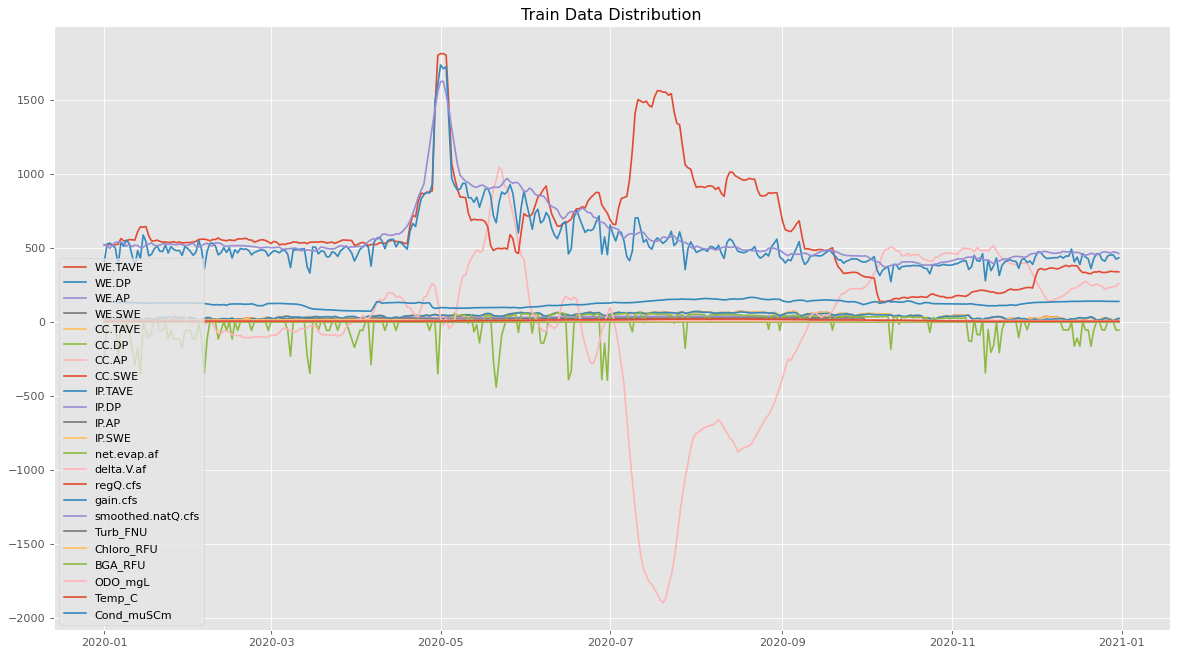

In [28]:
# Visualise train set for curiosity's sake
plt.figure(figsize=(18,10), dpi=80)
plt.plot(final_train['2020'])
plt.legend(final_train)
plt.title('Train Data Distribution');

## OLS Model

First, we determine feature importance for a simple model to give an idea of the weights of the explanatory variables on turbidity. An OLS model allows us to use multivariate regression to capture the variance in the data.

In [29]:
# Instantiate and fit the OLS model, and provide output
ols = OLS(exog=final_train.drop(['Turb_FNU'], axis=1), endog=final_train['Turb_FNU'])
ols_model = ols.fit()
print(ols_model.summary())

                                 OLS Regression Results                                
Dep. Variable:               Turb_FNU   R-squared (uncentered):                   0.785
Model:                            OLS   Adj. R-squared (uncentered):              0.782
Method:                 Least Squares   F-statistic:                              299.4
Date:                Wed, 24 Aug 2022   Prob (F-statistic):                        0.00
Time:                        17:12:55   Log-Likelihood:                         -3565.4
No. Observations:                1827   AIC:                                      7175.
Df Residuals:                    1805   BIC:                                      7296.
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [30]:
# Display standard deviations
final_train.std()

WE.TAVE               16.602699
WE.DP                  0.278735
WE.AP                 17.329576
WE.SWE                10.776551
CC.TAVE               16.611129
CC.DP                  0.193697
CC.AP                  9.495161
CC.SWE                 5.003882
IP.TAVE               16.159206
IP.DP                  0.169281
IP.AP                 10.288354
IP.SWE                 5.481206
net.evap.af          105.403773
delta.V.af           516.610946
regQ.cfs             336.144960
gain.cfs             219.347114
smoothed.natQ.cfs    235.757751
Turb_FNU               1.927556
Chloro_RFU             1.999588
BGA_RFU                0.641085
ODO_mgL                1.114011
Temp_C                 5.159372
Cond_muSCm            17.618043
dtype: float64

This adjusted R2 value shows that the variance in the turbidity is about 79% captured by the explanatory variables according to this model. This does not necessarily mean our model can't get any better than this, but it may represent a loose ballpark for the upper bounds of how accurately we can predict the turbidity using basic methods. Additionally, multicollinearity is high here, which is to be expected. This can be mitigated by eliminating columns or using models that eliminate multicollinearity issues going forward.

The Durbin-Watson score here is low, implying the variance of the data is not constant throughout. This makes sense in this case, as even though the data is from the same time frame, it comes from three completely different sources. This is something to keep in mind and can be eliminated using a transformation. 

The coefficients here represent the amount of change in turbidity for a one unit change in the explanatory variable in question. Higher values can denote a larger influence in this simple model, but it is important to take into mind the scale of the variable and compare, which is why the standard deviation is included for context. If the coefficient is large but the scale of the variable is also large, that might not mean as significant an influence.

The p values here also should be taken in with a grain of salt, as a p value lower than 0.05 should mean we can reject the null hypothesis that the variable has no influence on the turbidity, and the converse is also true, that if the p value is higher than 0.05 we can reject the alternative hypothesis that the variable does have a significant influence. Using our background knowledge however, we know that high amounts of chlorophyll and BGA are linked to higher turbidity, which does not seem to be the case in this regression.

From this, we see that the factors that have a direct impact via low p values and high coefficients relative to their scale are all temperatures at the Snotel sites, which are collinear, as well as the amount of snow at the Island Park and Crab Creek sites. As snow melts at the Crab Creek site, the turbidity increases at Island Park, and then as the amount of snow increases at Island Park, the turbidity also increases, reflecting the effects of increased inflow into the reservoir from this inlet and possibly the effects of inclement weather respectively, as in the latter the average precipitation also has a low p value. The amount of dissolved oxygen also negatively correlates with the turbidity, showing that the conditions that increase turbidity also decrease the amount of biologically available oxygen. The conductivity positively correlates with the turbidity, which tracks, as the amount of dissolved salts and other inorganic compounds could hamper water clarity.

## VAR Model

The VAR model is a multivariate timeseries model that allows us to quickly compare the past and present verisions of a dataset to examine their relationship. This model does well for recurring patterns, in our case seasonality. 

In [31]:
#creating the train and validation set
train = final_train_log.dropna()
valid = final_test_log.dropna()

In [32]:
#make final predictions
model = VAR(endog=train.dropna())
model_fit = model.fit(365)
yhat = model_fit.forecast(model_fit.endog, steps=365)

C:\Users\harri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [33]:
# Untransform and reformat the predictions
yhat_unt = pd.DataFrame((np.exp(yhat))-2172)
yhat_unt.set_index(final_test.index, inplace=True)
yhat_unt.columns = final_test.columns

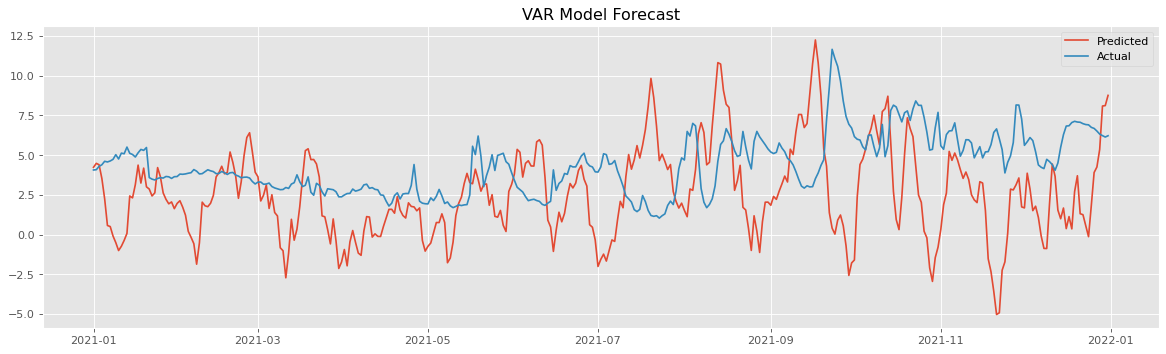

In [34]:
# Plot the predictions vs the actual values for 2021
plt.figure(figsize=(18,5), dpi=80)
plt.plot(yhat_unt['Turb_FNU'], label='Predicted')
plt.plot(final_test['Turb_FNU'], label='Actual')
plt.rcParams["figure.figsize"] = (20,3)
plt.title('VAR Model Forecast')
plt.legend();

In [35]:
# Calculate correlation between predictions and actual values
yhat_unt['Turb_FNU'].corr(final_test['Turb_FNU'])

-0.05003016615152072

In [36]:
# Calculate RMSE
dibrinse = ((final_test['Turb_FNU']**2)-yhat_unt['Turb_FNU'])
dibb = dibrinse.sum()
mse = dibb/365
rmse = np.sqrt(mse)
rmse

4.463655258001275

The above is the predicted values for Turbidity Using VAR. This result is if we were to predict the entire year without knowing any of the values for the predictor variables for the year. This shows that although the explanatory variables do contribute to the turbidity value, they themselves are not predictable for the time of year due to unpredictability in major contributing factors not explained by our data.

## LSTM Neural Network

Long Short Term Memory(LSTM) networks are a style of Recurrent Neural Network(RNN). RNNs are machine learning models that use the previous values to help predict the future values, and are the neural networks generally best suited to dealing with time series values. This works in theory, but these models tend toward stasis as they try to forecast further into the future. This essentially means that while the most recent values still affect the model, as the old ones get further from the current prediction, they begin to lose importance.

LSTM networks alleviate this problem by selectively forgetting information that it deems unimportant, while retaining the information it deems important. It determines the importance of the previous input using a sigmoid function to and then uses the same function along with the current input to create a vector telling the model how much of the new information to include in the new memory state. This new memory state is then retained and considered in with the next input, and so on.

In [37]:
# Make train and test sets
X_train = final_train.drop(['Turb_FNU'], axis=1)
y_train = final_train.Turb_FNU
X_test = final_test.drop(['Turb_FNU'], axis=1)
y_test = final_test.Turb_FNU

In [38]:
# Build the LSTM Neural Network

m = Sequential()
m.add(LSTM(units=50, return_sequences=True,
          input_shape=(X_train.shape[1],1)))
m.add(Dropout(0.2))
m.add(LSTM(units=50))
m.add(Dropout(0.1))
m.add(Dense(units=1))
m.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [39]:
# Fit the model to the data
history = m.fit(X_train, y_train, epochs=3000, batch_size=25, verbose=1)

# Plot the loss of the model as each epoch passes
plt.figure(figsize=(18,5), dpi=80)
plt.ylabel('Loss'); plt.xlabel('Epoch')
plt.semilogy(history.history['loss'])

Epoch 1/3000
74/74 [==============================] - 3s 8ms/step - loss: 4.4675
Epoch 2/3000
74/74 [==============================] - 1s 9ms/step - loss: 3.7134
Epoch 3/3000
74/74 [==============================] - 1s 8ms/step - loss: 3.3760
Epoch 4/3000
74/74 [==============================] - 1s 8ms/step - loss: 3.3091
Epoch 5/3000
74/74 [==============================] - 1s 8ms/step - loss: 3.2826
Epoch 6/3000
74/74 [==============================] - 1s 8ms/step - loss: 3.3251
Epoch 7/3000
74/74 [==============================] - 1s 8ms/step - loss: 3.2327
Epoch 8/3000
74/74 [==============================] - 1s 8ms/step - loss: 3.2480
Epoch 9/3000
74/74 [==============================] - 1s 8ms/step - loss: 3.1836
Epoch 10/3000
74/74 [==============================] - 1s 9ms/step - loss: 3.2118
Epoch 11/3000
74/74 [==============================] - 1s 9ms/step - loss: 3.1684
Epoch 12/3000
74/74 [==============================] - 1s 8ms/step - loss: 3.1571
Epoch 13/3000
74/74 [====

KeyboardInterrupt: 

In [ ]:
# Use the fitted LSTM to predict on the test set
y_pred = m.predict(X_test)
y_pred = pd.DataFrame(y_pred)
y_pred.set_index(X_test.index, inplace=True)

In [ ]:
# Plot the LSTM results
plt.figure(figsize=(18,5), dpi=80)
plt.plot(y_pred,label='LSTM')
plt.plot(y_test,label='Actual')
plt.title('LSTM Model')
plt.legend();

In [ ]:
# Calculate correlation between predictions and actual values
pd.DataFrame(y_test)['Turb_FNU'].corr(pd.DataFrame(y_pred)[0])

In [ ]:
# Calculate RMSE
dibrinse = (pd.DataFrame(y_test)['Turb_FNU']-pd.DataFrame(y_pred)[0])
dibb = dibrinse.sum()
mse = dibb/365
rmse = np.sqrt(mse)
rmse

The predicted and actual values for turbidity in 2021 are displayed in the graph above. Many of the peaks and valleys match up even though their magnitude may not always match. RMSE value averages the square of all the errors, and then takes the square root to get the number back into the scale of the data. The RMSE here is relatively low, roughly a third of that of the VAR model, and shows that for any given point in time, the model is on average only off by 1.3.

The drawback of this model is that the data you provide it will often already contain the turbidity value, given the sonde. It can, however, be used to estimate the turbidity in cases where forecasting is required, and where we have an idea going in of what the values for the predictors might be, as in the prediction for 2021.